# Simulation

The simulator allows to observe the behavior of the system under a given policy.

The following policies are provided:

In [1]:
import stochastic_matching as sm
sm.common.get_classes(sm.Simulator)

{'fcfm': stochastic_matching.simulator.fcfm.FCFM,
 'priority': stochastic_matching.simulator.priority.Priority,
 'random_edge': stochastic_matching.simulator.random_edge.RandomEdge,
 'random_item': stochastic_matching.simulator.random_item.RandomItem,
 'e_filtering': stochastic_matching.simulator.e_filtering.EFiltering,
 'longest': stochastic_matching.simulator.longest.Longest,
 'virtual_queue': stochastic_matching.simulator.virtual_queue.VirtualQueue}

NB: only simple graphs are considered in the present notebook.

## Tadpole

### Bijective

Consider the following tadpole:

In [2]:
from stochastic_matching.display import VIS_OPTIONS
VIS_OPTIONS['height'] = 300
tadpole = sm.Tadpole(m=5, n=3, rates='uniform')
tadpole.show_graph()

This tadpole is not stabilizable: it is bijective and its unique solution has null edges.

In [3]:
tadpole.show_flow()

As a consequence, the system is unstable.

In [4]:
tadpole.run('fcfm', n_steps=10000000)

False

The simulator finished before the end (due to queue overflow).

In [5]:
tadpole.simulator.logs.steps_done

906433

In [6]:
tadpole.show_flow()

We can look the CCDFs of the run to see what went wrong:

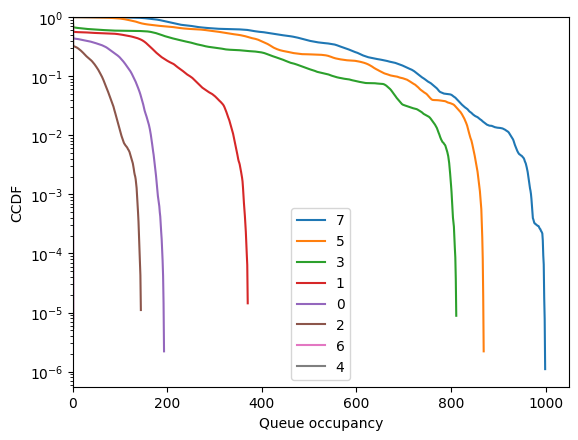

In [7]:
fig = tadpole.simulator.show_ccdf(sort=True)

Node 7 overflowed, while node 5 was not in a good shape either.

This can also be showed with average queue sizes:

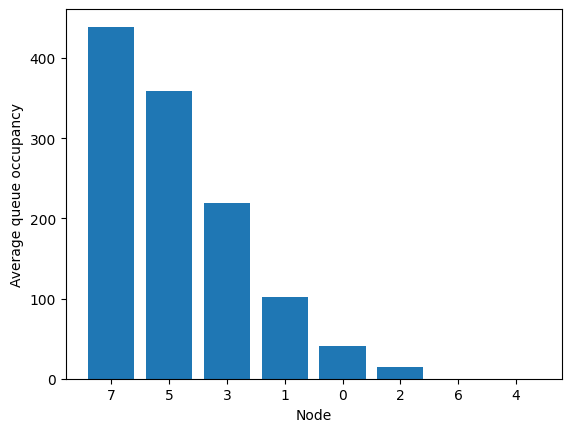

In [8]:
fig = tadpole.simulator.show_average_queues(sort=True)

Let's change the arrival rates to have something nicer.

In [9]:
tadpole.rates = [1, 1, 1, 1, 2, 2, 2, 1]

We can see that it works!

In [10]:
tadpole.run('fcfm', n_steps=10000000)

True

In [11]:
tadpole.show_flow()

We can see that the queues are much more tight!

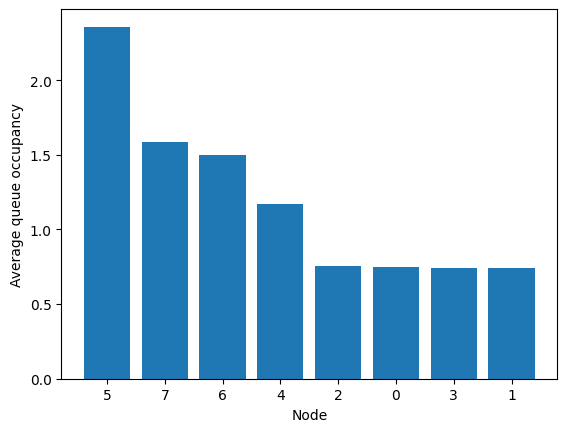

In [12]:
fig = tadpole.simulator.show_average_queues(sort=True)

Note that the average queue can be converted in an average waiting time.

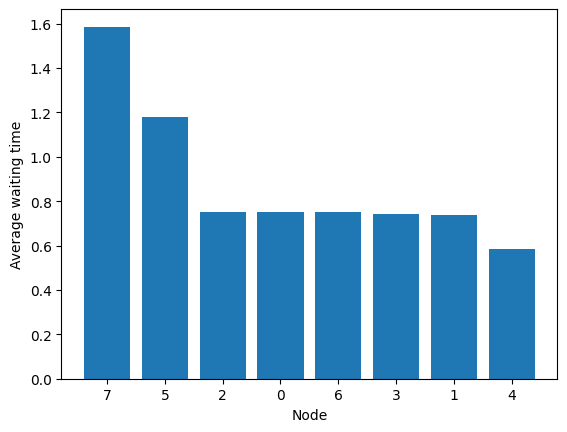

In [13]:
fig = tadpole.simulator.show_average_queues(sort=True, as_time=True)

### Nonjective

Consider the following tadpole:

In [14]:
tadpole = sm.Tadpole(rates='uniform', m=4)

It is bipartite and does not verify the stability condition NCond (even bipartite NCond), so all solution break the conservation law.

Simulation fails:

In [15]:
tadpole.run('fcfm', n_steps=10000000, max_queue=100000)

False

In [16]:
tadpole.show_flow()

Nodes 0, 2, and 4 are in limbo.

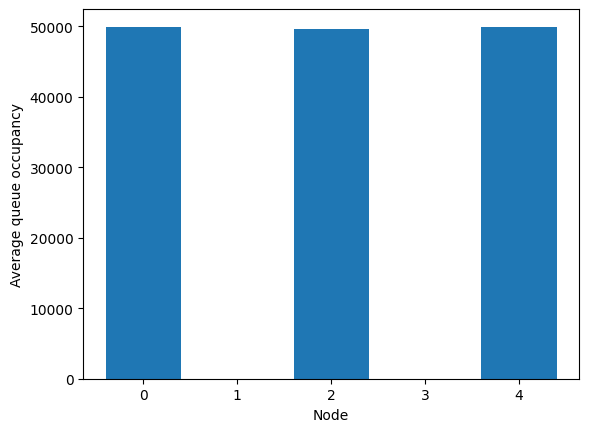

In [17]:
fig = tadpole.simulator.show_average_queues()

Let's change the arrival rates to have bipartite NCond (which is not non-bipartite NCond).

In [18]:
tadpole.rates = [1, 1, 1, 2, 1]

In [19]:
tadpole.run('fcfm', n_steps=1000000)

True

We can see that it works! FCFM seems to stabilizes even if NCond is not met.

In [20]:
tadpole.show_flow()

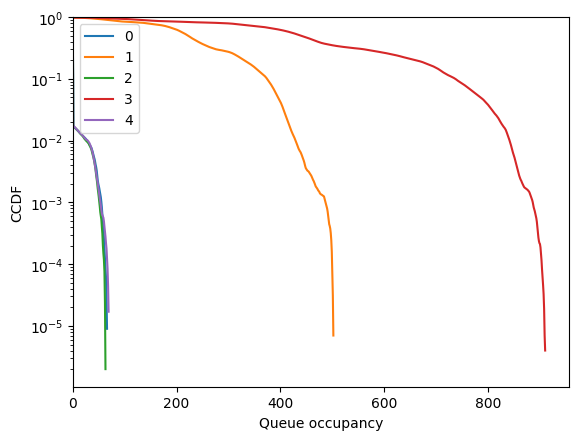

In [21]:
fig = tadpole.simulator.show_ccdf()

Hum, the queues are quite high. Maybe we didn't wait long enough?

In [22]:
tadpole.run('fcfm', n_steps=10000000, seed=42)

False

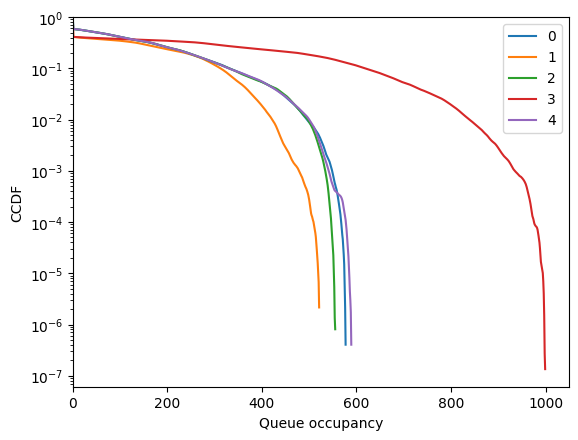

In [23]:
fig = tadpole.simulator.show_ccdf()

Not so stable after all... This is not surprising because of the random walk between left and right nodes, which forces queues of arbitrary size if one waits long enough.

## Diamond

Consider the following:

In [24]:
diamond = sm.CycleChain(tol=1e-3)
ϵ = 0.2
diamond.rates = [2, 2+ϵ, 1+ϵ, 1]

Try fcfm

In [25]:
diamond.run('fcfm', n_steps=10000000)

True

In [26]:
diamond.show_flow()

Nodes 0 and 3 are non-empty most of the time.

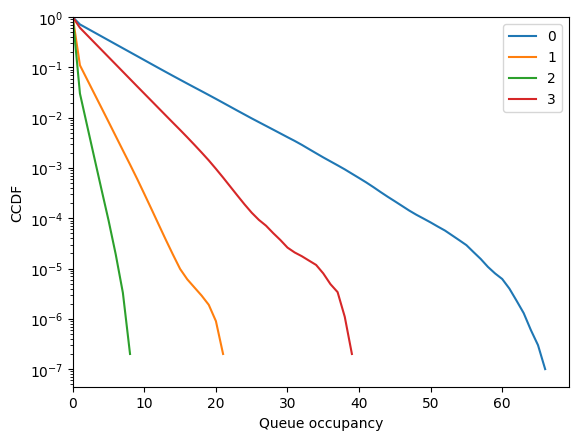

In [27]:
fig = diamond.simulator.show_ccdf()

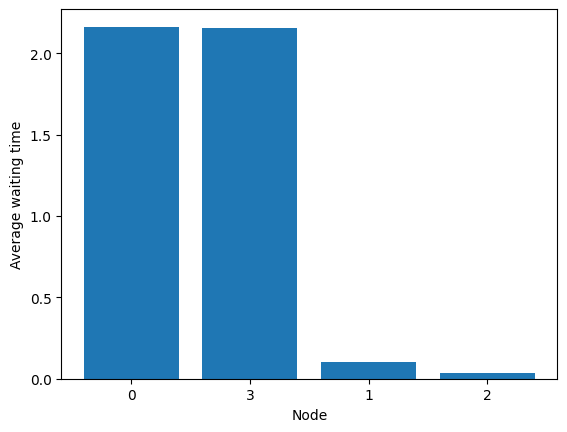

In [28]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

Try random edge (we use a seed to have a True result; in practice, random node is highly borderline in this example and overflows relatively often).

In [29]:
diamond.run('random_edge', n_steps=10000000, seed=42)

True

In [30]:
diamond.show_flow()

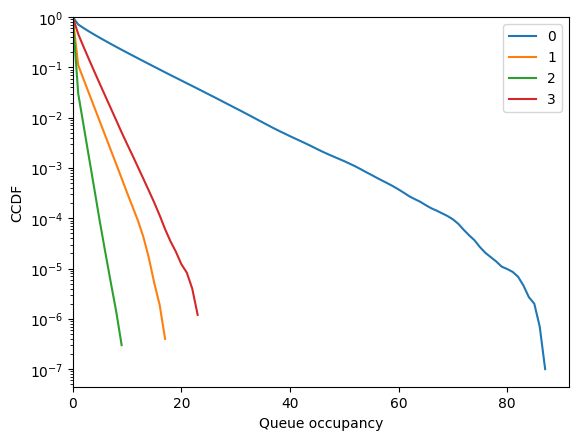

In [31]:
fig = diamond.simulator.show_ccdf()

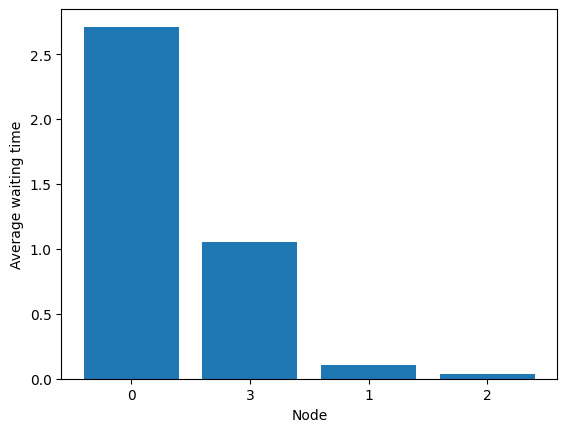

In [32]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

Try random item.

In [33]:
diamond.run('random_item', n_steps=10000000)

True

In [34]:
diamond.show_flow()

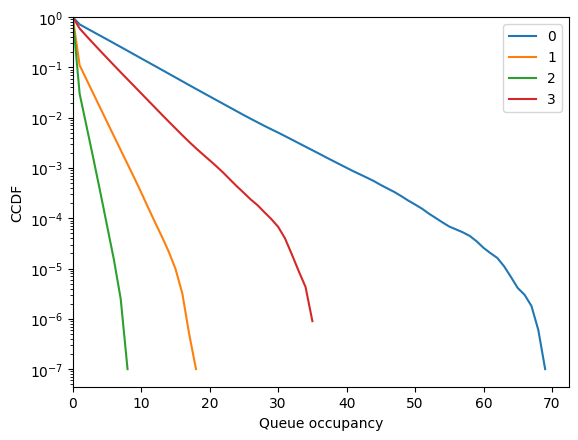

In [35]:
fig = diamond.simulator.show_ccdf()

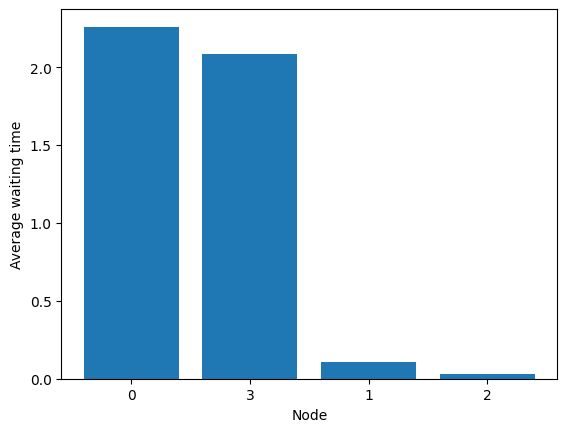

In [36]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

### Trying to reach an extreme feasible solution with a greedy policy

Now we would like to have a greedy policy that tries to move on towards the extreme feasible solutions. Sadly, no such policy exists (cf https://hal.archives-ouvertes.fr/hal-03502084).

Yet, we can try to approach them with priority-based greedy selection. First, look at the extreme points (vertices).

In [37]:
diamond = sm.CycleChain(rates=[2, 2.2, 1.2, 1])
for i in range(len(diamond.vertices)):
    diamond.show_vertex(i)

We can see that the first vertex prioritizes edges 1 and 3, while the second one prioritizes edges 0 and 4. Let us see what happens if one uses these priorities in a greedy policy.

In [38]:
diamond.run('priority', weights=[0, 1, 0, 1, 0], n_steps=10000000)
diamond.show_flow()

In [39]:
diamond.run('priority', weights=[1, 0, 0, 0, 1], n_steps=10000000)
diamond.show_flow()

Not bad, but not perfect. To reach a vertex, we may need to use a filtering policy.

### Trying to reach an extreme feasible solution with a filtering policy

In [40]:
diamond.vertices

[{'kernel_coordinates': array([-0.25]),
  'edge_coordinates': array([1. , 1. , 0.2, 1. , 0. ]),
  'null_edges': [4],
  'bijective': True},
 {'kernel_coordinates': array([0.75]),
  'edge_coordinates': array([2. , 0. , 0.2, 0. , 1. ]),
  'null_edges': [1, 3],
  'bijective': False}]

The first kernel is bijective, we just need to forbid the null edge.

In [41]:
diamond.run('longest', forbidden_edges=diamond.vertices[0]['null_edges'], n_steps=10000000)

True

In [42]:
diamond.show_flow()

We can check that the matching rate on edge 4 is 0.

In [43]:
diamond.simulation

array([1.00047808, 0.99915264, 0.20158848, 0.99878016, 0.        ])

No noticeable impact on the performance.

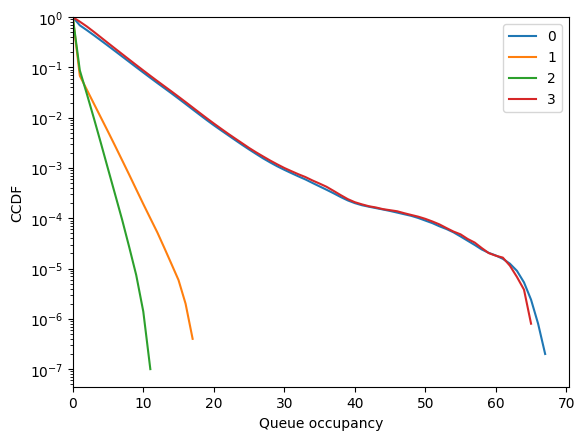

In [44]:
fig = diamond.simulator.show_ccdf()

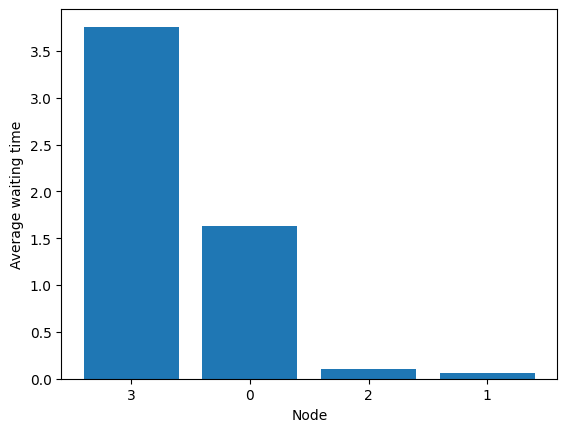

In [45]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

Now we try on the second kernel.

In [46]:
diamond.run('longest', forbidden_edges=diamond.vertices[1]['null_edges'], n_steps=10000000)

False

In [47]:
diamond.show_flow()

So this is unstable but the the matching rate on edges 1 and 3 is 0.

In [48]:
diamond.simulation

array([1.99957622, 0.        , 0.20045326, 0.        , 0.99910573])

Performance is bad, as the vertex is injective-only (bipartite).

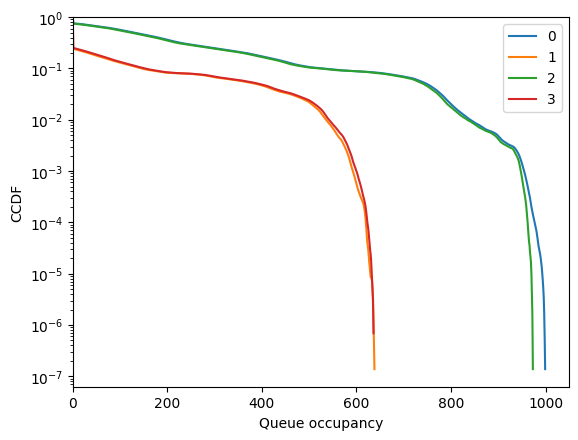

In [49]:
fig = diamond.simulator.show_ccdf()

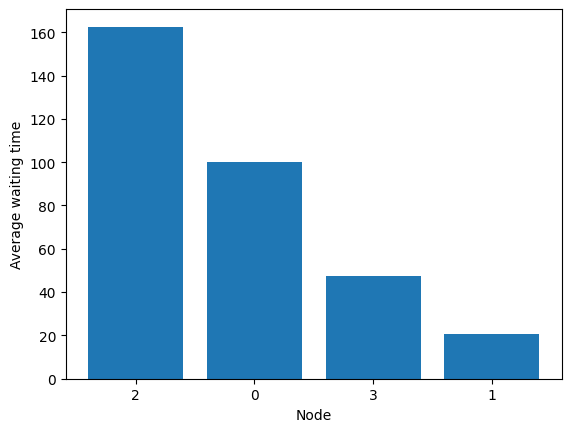

In [50]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

The solution in that case is to use a k-filtering policy (i.e. with threshold).

In [51]:
diamond.run('longest', forbidden_edges=diamond.vertices[1]['null_edges'], k=500, n_steps=10000000)

True

In [52]:
diamond.show_flow()

So this is stable with a limited matching rate on edges 1 and 3.

In [53]:
diamond.simulation

array([1.9995712e+00, 1.5276800e-03, 1.9951488e-01, 1.9712000e-04,
       9.9900160e-01])

Performance is controlled by the threshold.

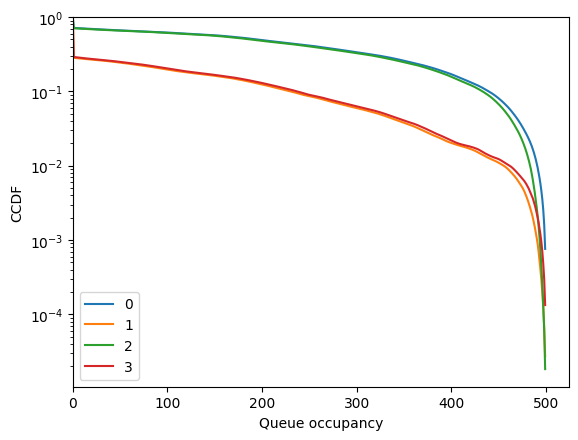

In [54]:
fig = diamond.simulator.show_ccdf()

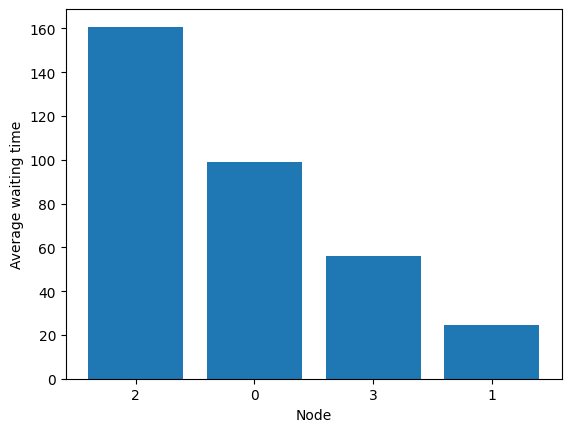

In [55]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

### Reward maximization variant

In many use cases, one may want to optimize the flow based on some reward associated to each edge. It turns out that this equivalent to finding a subset of edges to forbid such that the flow(s) on that subgraph will maximize the reward. `stochastic_matching` automatically implements this in two ways:
- It gives an optimal flow associated to a vector of rewards;
- the filtering policy can take a vector of rewards as arguments and automatically discard the null edges of one optimal solution.

In [56]:
rewards = [2, 1, 2, 1, 2]
diamond.optimize_rates(rewards)

array([2. , 0. , 0.2, 0. , 1. ])

In [57]:
diamond.run('longest', rewards=rewards, k=300, forbidden_edges=True)

True

In [58]:
diamond.show_flow()

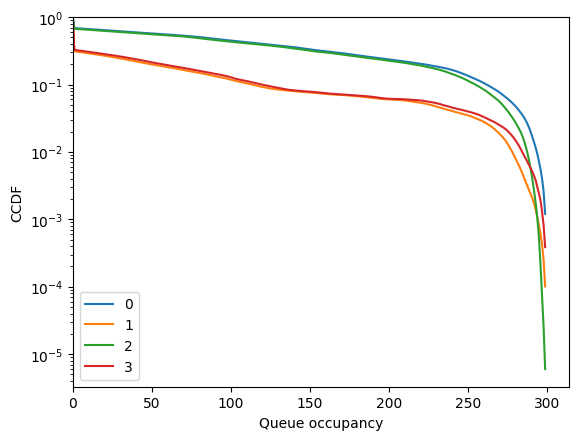

In [59]:
fig = diamond.simulator.show_ccdf()

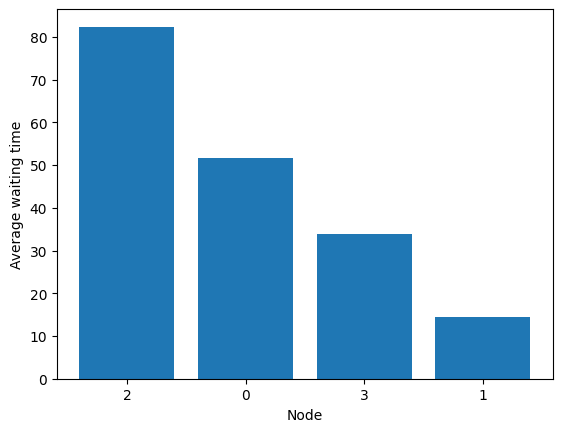

In [60]:
fig = diamond.simulator.show_average_queues(sort=True, as_time=True)

## Fish

The purpose of this example is to show a case where a family of greedy with priorities can asymptotically reach the vertices.

In [61]:
fish = sm.KayakPaddle(l=0, m=4, names=[str(i) for i in range(1, 7)], rates = [4, 4, 3, 2, 3, 2])
fish.show_graph()

Look at the vertices:

In [62]:
for i in range(len(fish.vertices)):
    fish.show_vertex(i, disp_rates=False)

Let us try to nullify the edge between 3 and 6 with adapted priorities. As this may be unstable, let us pick a large max queue.

In [63]:
rewards = [0, 2, 2, 1, 0, 0, 1]
fish.run('priority', weights=rewards, n_steps=10000000, max_queue=1000000)

True

In [64]:
fish.show_flow(disp_rates=False)

So we managed to almost nullify the edge at the price of making node 4 unstable (it cannot check the conservation law). This can be addressed by using a threshold above which the policy is altered.

In [65]:
counterweights = [0, 1, 1, 2, 0, 0, 2]

In [66]:
fish.run('priority', weights=rewards, n_steps=10000000, threshold=500, counterweights=counterweights)

True

In [67]:
fish.show_flow(disp_rates=False)

And that's it! The threshold controls the trade-off between the size of queue 4 and the nullity of edge (3, 6).

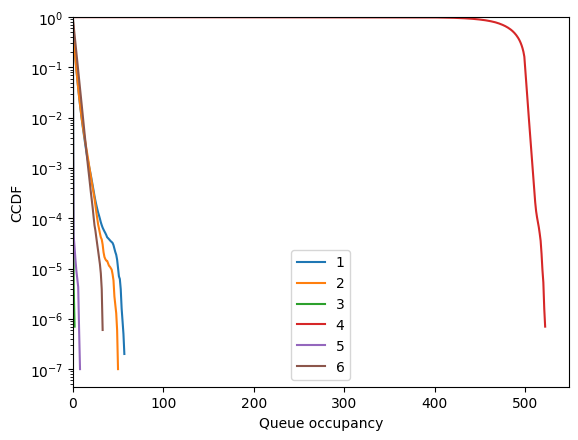

In [68]:
fig = fish.simulator.show_ccdf()

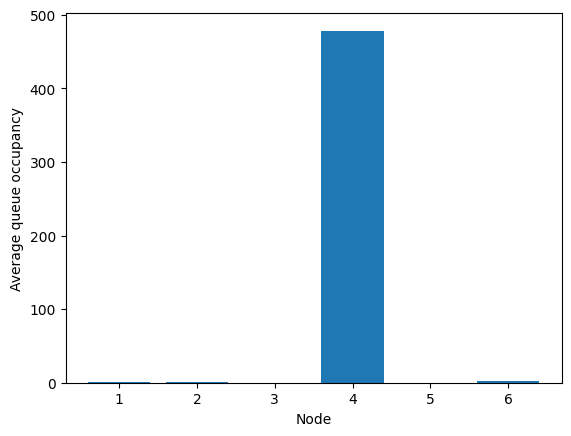

In [69]:
fig = fish.simulator.show_average_queues()

In [70]:
fish.run('priority', weights=rewards, n_steps=10000000, threshold=10, counterweights=counterweights)

True

In [71]:
fish.show_flow(disp_rates=False)

And that's it! The threshold controls the trade-off between the size of queue 4 and the nullity of edge (3, 6).

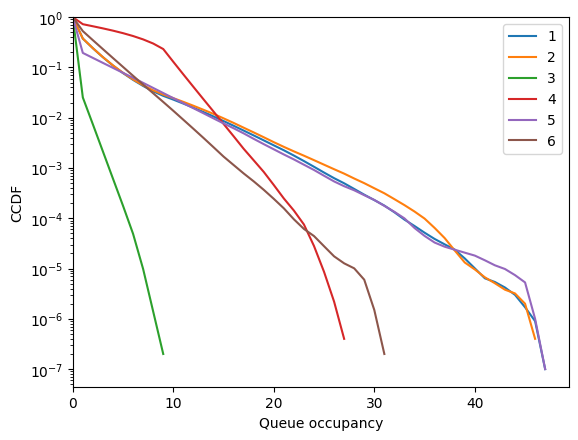

In [72]:
fig = fish.simulator.show_ccdf()

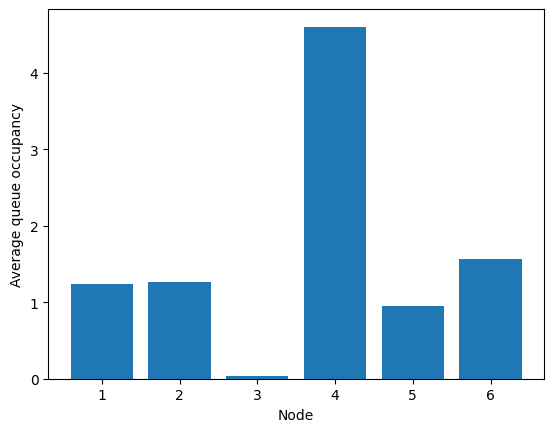

In [73]:
fig = fish.simulator.show_average_queues()

Last possibility: use a reward-based greedy scoring.

In [74]:
fish.run('longest', rewards=rewards, n_steps=10000000, beta=.01, shift_rewards=True)

True

In [75]:
fish.show_flow(disp_rates=False)

And that's it! Beta controls the trade-off between the size of queue 4 and the nullity of edge (3, 6).

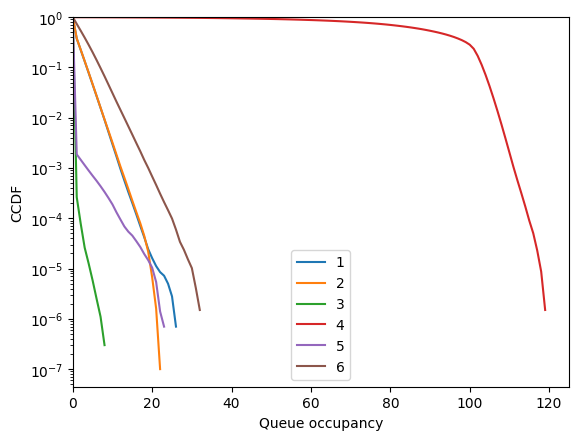

In [76]:
fig = fish.simulator.show_ccdf()

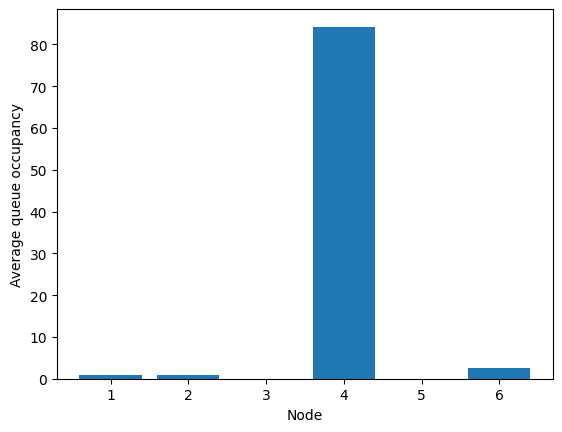

In [77]:
fig = fish.simulator.show_average_queues()

In [78]:
fish.run('longest', rewards=rewards, n_steps=10000000, beta=.1, shift_rewards=True)

True

In [79]:
fish.show_flow(disp_rates=False)

And that's it! Beta controls the trade-off between the size of queue 4 and the nullity of edge (3, 6).

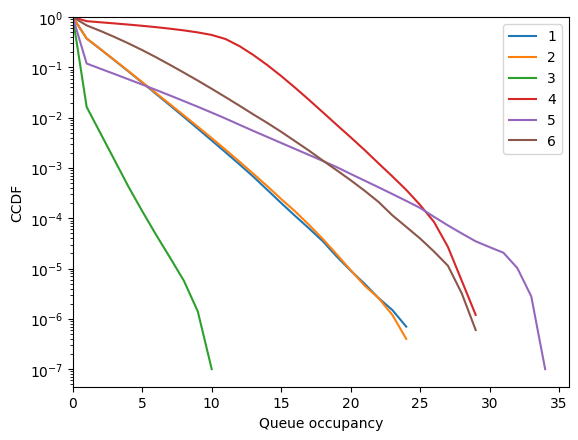

In [80]:
fig = fish.simulator.show_ccdf()

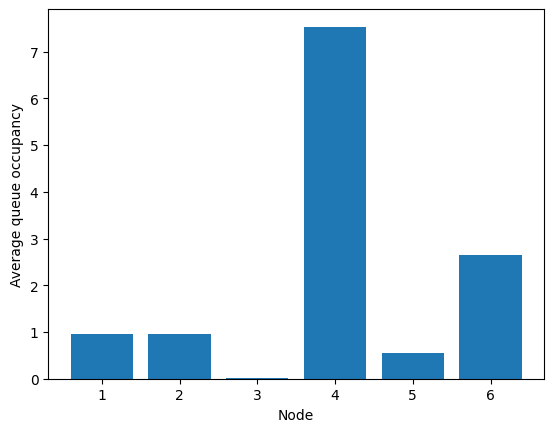

In [81]:
fig = fish.simulator.show_average_queues()

## Reaching a highly degenerated vertex

The following model has *very injective* vertices.

In [82]:
import numpy as np
codomino = sm.Codomino(rates=[2, 4, 2, 2, 4, 2])
codomino.base_flow = np.array([1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0])
codomino.vertices

[{'kernel_coordinates': array([-1., -1.]),
  'edge_coordinates': array([0., 2., 0., 4., 0., 0., 2., 0.]),
  'null_edges': [0, 2, 4, 5, 7],
  'bijective': False},
 {'kernel_coordinates': array([-1.,  1.]),
  'edge_coordinates': array([2., 0., 0., 2., 2., 0., 0., 2.]),
  'null_edges': [1, 2, 5, 6],
  'bijective': False},
 {'kernel_coordinates': array([1., 1.]),
  'edge_coordinates': array([2., 0., 2., 0., 0., 2., 0., 2.]),
  'null_edges': [1, 3, 4, 6],
  'bijective': False}]

In particular the first vertex is made of three unconnected pairs:

In [83]:
codomino.show_vertex(0)

Let try to reach it with a filtering policy without threshold.

In [84]:
codomino.run('longest', forbidden_edges=codomino.vertices[0]['null_edges'], n_steps=10000000, max_queue=100000)

True

In [85]:
codomino.show_flow()

As this is pure filtering, the desired edges are indeed null.

In [86]:
codomino.simulation

array([0.       , 1.9977536, 0.       , 3.9996384, 0.       , 0.       ,
       2.0006656, 0.       ])

But performance is awful!

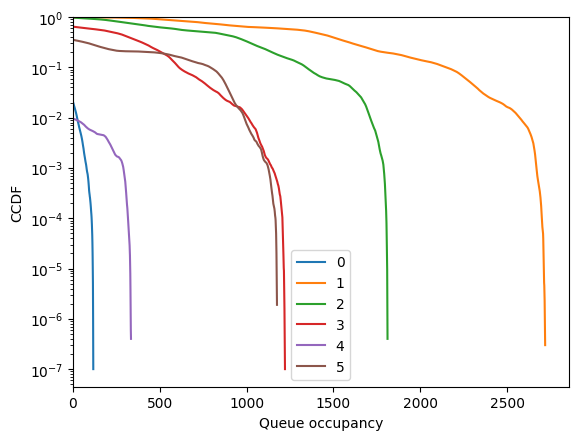

In [87]:
fig = codomino.simulator.show_ccdf()

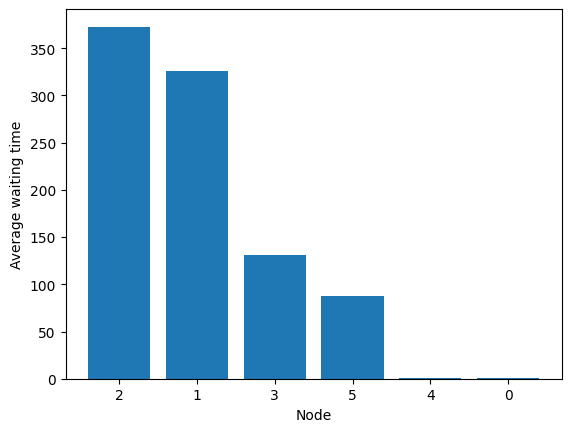

In [88]:
fig = codomino.simulator.show_average_queues(sort=True, as_time=True)

A solution in that case is to use a $k$-filtering policy (i.e. with threshold).

In [89]:
codomino.run('longest', forbidden_edges=codomino.vertices[0]['null_edges'], k=900, n_steps=10000000)

True

In [90]:
codomino.show_flow()

So this is stable with a limited matching rate on forbidden edges.

In [91]:
codomino.simulation

array([3.0672000e-03, 1.9972304e+00, 0.0000000e+00, 3.9954352e+00,
       0.0000000e+00, 2.9280000e-03, 1.9968848e+00, 3.7328000e-03])

Performance is controlled by the threshold.

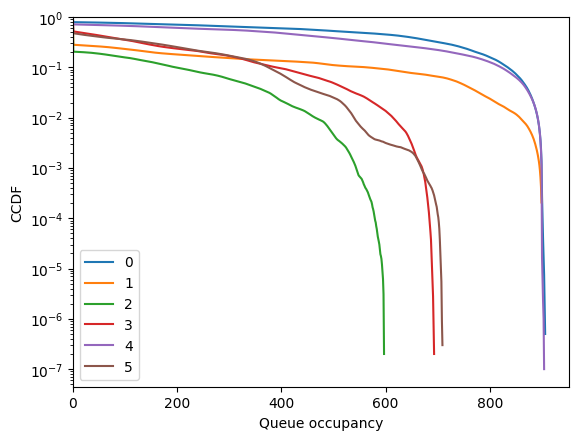

In [92]:
fig = codomino.simulator.show_ccdf()

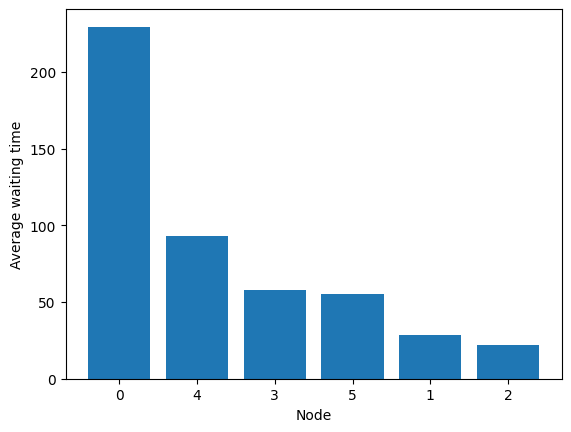

In [93]:
fig = codomino.simulator.show_average_queues(sort=True, as_time=True)

In [94]:
codomino.run('longest', forbidden_edges=codomino.vertices[0]['null_edges'], k=50, n_steps=10000000)

True

In [95]:
codomino.show_flow()

In [96]:
codomino.simulation

array([0.0443776, 1.9524512, 0.0306336, 3.9258976, 0.0123232, 0.0332736,
       1.9575072, 0.0435152])

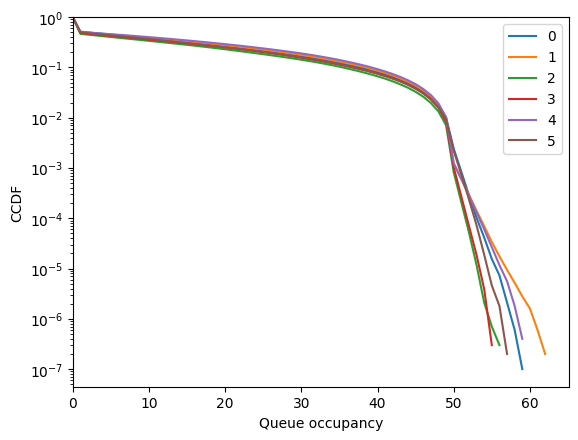

In [97]:
fig = codomino.simulator.show_ccdf()

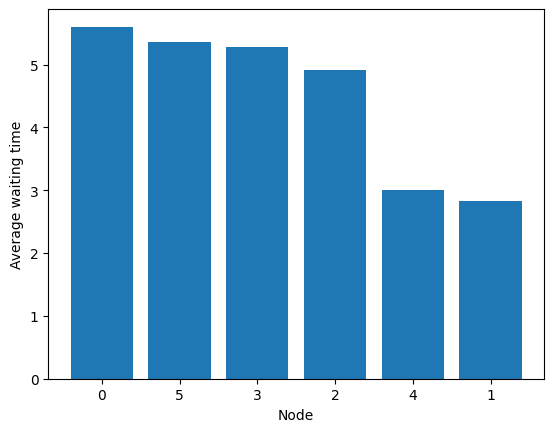

In [98]:
fig = codomino.simulator.show_average_queues(sort=True, as_time=True)

Other filtering policies exists:

In [99]:
codomino.run('e_filtering', forbidden_edges=codomino.vertices[0]['null_edges'], epsilon=.01, n_steps=10000000)

True

In [100]:
codomino.show_flow()

In [101]:
codomino.simulation

array([0.027568 , 1.9696768, 0.0203312, 3.9526368, 0.0098112, 0.0194064,
       1.9728544, 0.0276576])

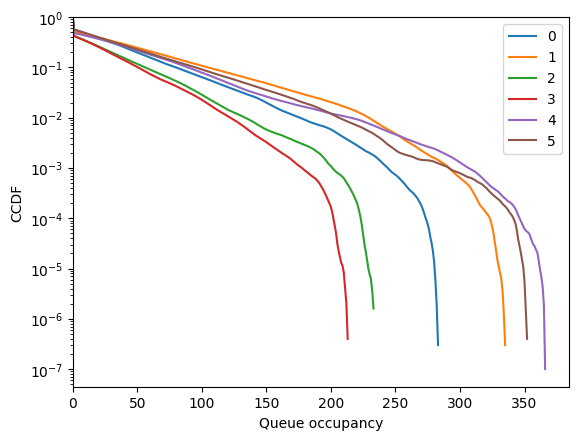

In [102]:
fig = codomino.simulator.show_ccdf()

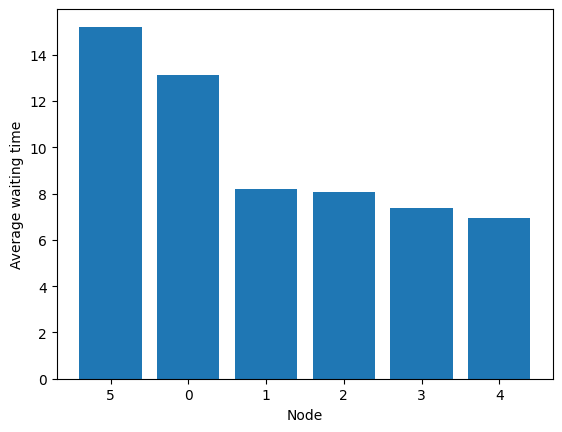

In [103]:
fig = codomino.simulator.show_average_queues(sort=True, as_time=True)

In [104]:
rewards = [1 * (i not in codomino.vertices[0]['null_edges']) for i in range(8)]
rewards

[0, 1, 0, 1, 0, 0, 1, 0]

In [105]:
codomino.run('virtual_queue', rewards=rewards, beta=.01, n_steps=10000000)

True

In [106]:
codomino.show_flow()

In [107]:
codomino.simulation

array([8.2896000e-03, 1.9915008e+00, 5.9280000e-03, 3.9822880e+00,
       3.2800000e-03, 9.3072000e-03, 1.9884384e+00, 1.0620800e-02])

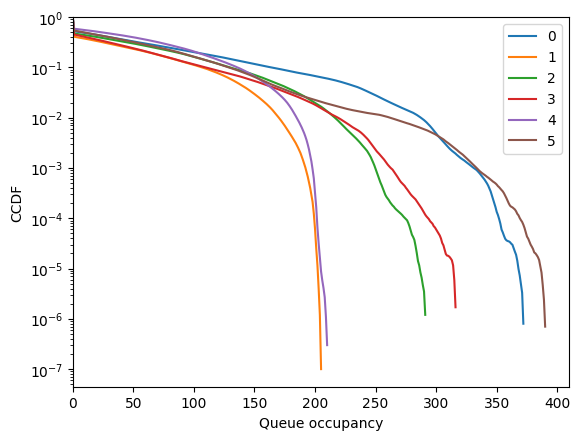

In [108]:
fig = codomino.simulator.show_ccdf()

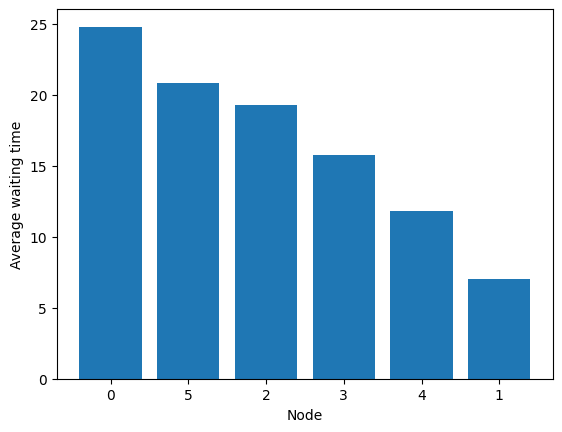

In [109]:
fig = codomino.simulator.show_average_queues(sort=True, as_time=True)